In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential, Model
from keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, 
    AveragePooling2D, GlobalAveragePooling2D, Input, ReLU, MaxPooling2D,Concatenate
)
from keras.optimizers import Adam, Adamax
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# define project constants 
IMAGE_SIZE=80 
COLORS = 3
INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,COLORS)
BATCH_SIZE = 64
RANDOM_STATE = 42
classification_types=['Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
                      'Potato___Early_blight','Potato___Late_blight','Potato___healthy',
                      'Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight',
                      'Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot',
                      'Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot',
                      'Tomato__Tomato_YellowLeaf__Curl_Virus',
                      'Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '../PlantVillage'
train_dir = os.path.join(data_dir)
print(train_dir)

../PlantVillage


In [3]:
train_data=[]
for id, disease in enumerate(classification_types):
    dir = os.path.join(data_dir,disease)
    for file in os.listdir(dir):
        train_data.append([os.path.join(disease,file),id,disease,os.path.join(dir,file)])


train = pd.DataFrame(train_data,columns=['File','DiseaseID','Disease_Type','File_Path'])
train.head()

,File,DiseaseID,Disease_Type,File_Path
0,Pepper__bell___Bacterial_spot/47fbd17d-c078-44...,0,Pepper__bell___Bacterial_spot,../PlantVillage/Pepper__bell___Bacterial_spot/...
1,Pepper__bell___Bacterial_spot/42ef264d-f255-46...,0,Pepper__bell___Bacterial_spot,../PlantVillage/Pepper__bell___Bacterial_spot/...
2,Pepper__bell___Bacterial_spot/435993b8-c7f7-47...,0,Pepper__bell___Bacterial_spot,../PlantVillage/Pepper__bell___Bacterial_spot/...
3,Pepper__bell___Bacterial_spot/1fca0f2b-857b-4c...,0,Pepper__bell___Bacterial_spot,../PlantVillage/Pepper__bell___Bacterial_spot/...
4,Pepper__bell___Bacterial_spot/9cee73cb-272f-41...,0,Pepper__bell___Bacterial_spot,../PlantVillage/Pepper__bell___Bacterial_spot/...


In [4]:
train = train.sample(frac=1,random_state=RANDOM_STATE)
train.reset_index(drop=True, inplace=True)
train.head()

,File,DiseaseID,Disease_Type,File_Path
0,Tomato_healthy/c3724cd0-50c4-4780-8dc8-fe3e9d0...,14,Tomato_healthy,../PlantVillage/Tomato_healthy/c3724cd0-50c4-4...
1,Potato___Early_blight/e6693b54-623a-4323-aa79-...,2,Potato___Early_blight,../PlantVillage/Potato___Early_blight/e6693b54...
2,Tomato_Septoria_leaf_spot/adf85c8b-07e2-4f8c-a...,9,Tomato_Septoria_leaf_spot,../PlantVillage/Tomato_Septoria_leaf_spot/adf8...
3,Tomato_healthy/ac249839-fe21-45cd-9e09-f0023fa...,14,Tomato_healthy,../PlantVillage/Tomato_healthy/ac249839-fe21-4...
4,Tomato_Leaf_Mold/fe0bcd7f-a7de-4155-95a5-79043...,8,Tomato_Leaf_Mold,../PlantVillage/Tomato_Leaf_Mold/fe0bcd7f-a7de...


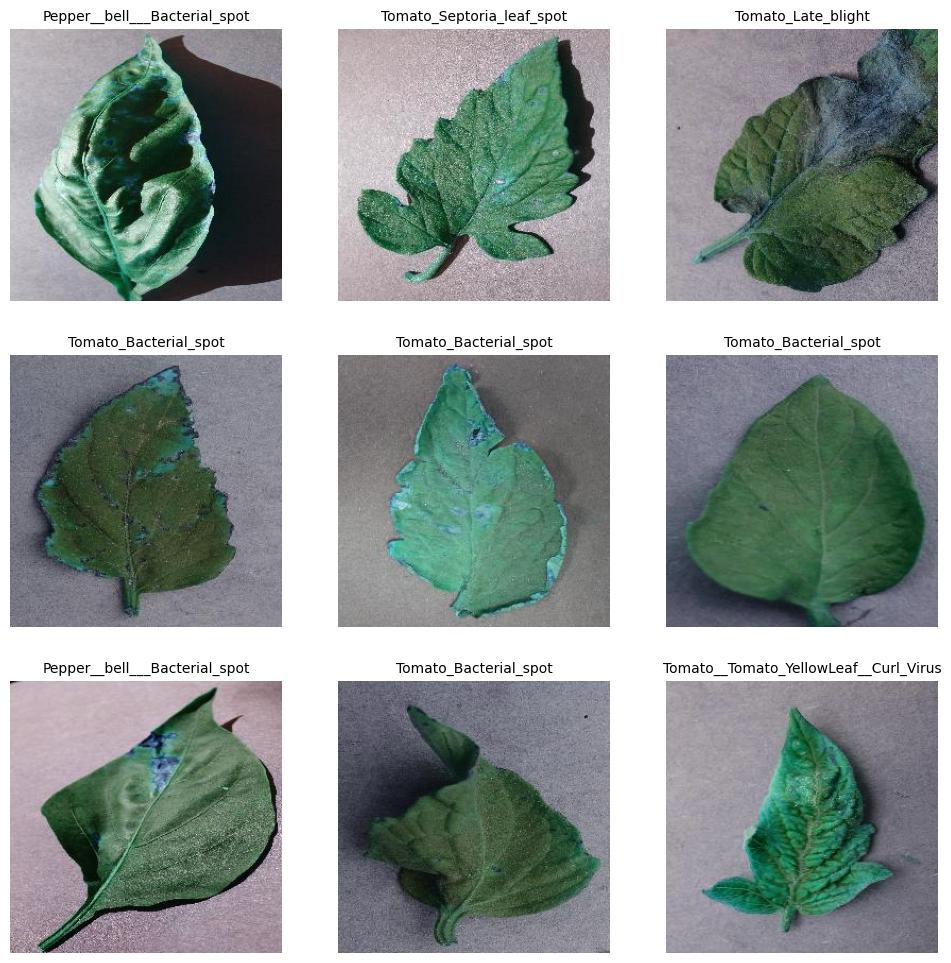

In [5]:
def display_random_images(rows,cols):
    fig, ax = plt.subplots(rows,cols,figsize=(12,12))
    random = train.sample(rows*cols)

    for i in range(rows):
        for j in range(cols):
            row_data = random.iloc[i * cols + j]
            image_path = os.path.join(data_dir, row_data['File'])
            disease_type = row_data['Disease_Type']
            ax[i,j].imshow(cv2.imread(image_path))
            ax[i,j].axis('off')
            ax[i, j].set_title(disease_type, fontsize=10)

display_random_images(3,3)

In [6]:
def get_training_data():
    data = np.zeros((train.shape[0],IMAGE_SIZE,IMAGE_SIZE,COLORS))
    for i, file in tqdm(enumerate(train['File'].values)):
        img = cv2.imread(os.path.join(data_dir,file))
        if img is not None:
            img_resized = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
            img_resized = img_resized/255
            data[i]=img_resized
    return data

X = get_training_data()

20639it [00:16, 1287.13it/s]


In [7]:
X.shape

(20639, 80, 80, 3)

In [8]:
y = to_categorical(train['DiseaseID'],num_classes=np.unique(train['DiseaseID']).size)
print(y.shape)

(20639, 15)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)

In [10]:
NUM_CLASSES = int(np.unique(train['DiseaseID']).size)

In [11]:
print(f'x train shape is {X_train.shape}')
print(f'x val shape is {X_val.shape}')
print(f'y train shape is {y_train.shape}')
print(f'y val shape is {y_val.shape}')

x train shape is (16511, 80, 80, 3)
x val shape is (4128, 80, 80, 3)
y train shape is (16511, 15)
y val shape is (4128, 15)


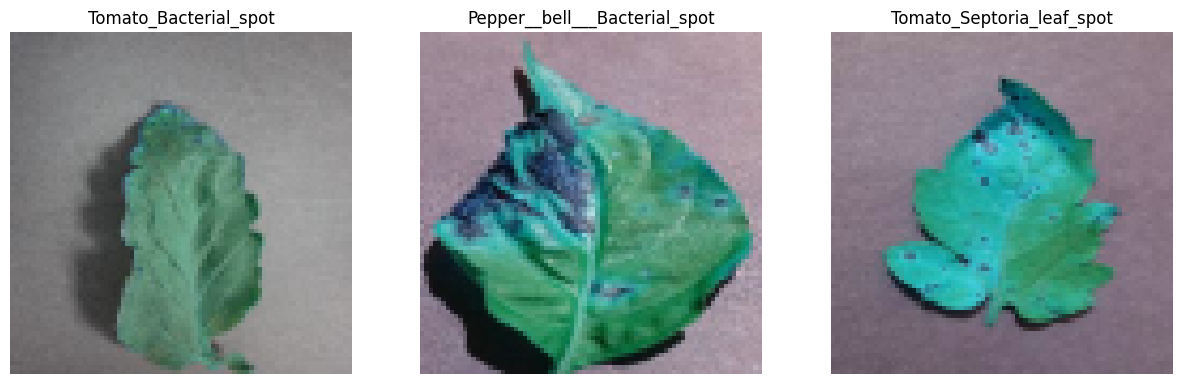

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(classification_types[np.argmax(y_train[i])])

In [13]:
base_model=Xception(weights='imagenet',include_top=False,pooling='avg',
                    input_shape=INPUT_SHAPE)
base_model.trainable=False
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dropout(0.45))
model.add(Dense(220,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(60,activation='relu'))
model.add(Dense(NUM_CLASSES,activation='softmax',name='root'))

optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

/Users/usamamohiuddin/Documents/PlantDiseaseDetection/venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 15)             │           915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,334,627 (81.39 MB)

 Trainable params: 469,051 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train,y_train,
                        epochs= 10,
                        validation_data = (X_val,y_val),
                        callbacks = early_stopping)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 85s 162ms/step - accuracy: 0.2337 - loss: 2.6809 - val_accuracy: 0.6284 - val_loss: 1.1802
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 89s 173ms/step - accuracy: 0.5402 - loss: 1.4291 - val_accuracy: 0.7202 - val_loss: 0.8789
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 102s 198ms/step - accuracy: 0.6166 - loss: 1.1696 - val_accuracy: 0.7442 - val_loss: 0.7758
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 117s 227ms/step - accuracy: 0.6579 - loss: 1.0206 - val_accuracy: 0.7648 - val_loss: 0.7062
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 124s 241ms/step - accuracy: 0.6833 - loss: 0.9668 - val_accuracy: 0.7699 - val_loss: 0.6675
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 126s 244ms/step - accuracy: 0.6956 - loss: 0.9041 - val_accuracy: 0.7808 - val_loss: 0.6449
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 127s 247ms/step - accuracy: 0.7097 - loss: 0.8709 - val_accuracy: 0.7948 - val_loss: 0.6157
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 114s 222ms/step - accuracy: 0.7166 - l

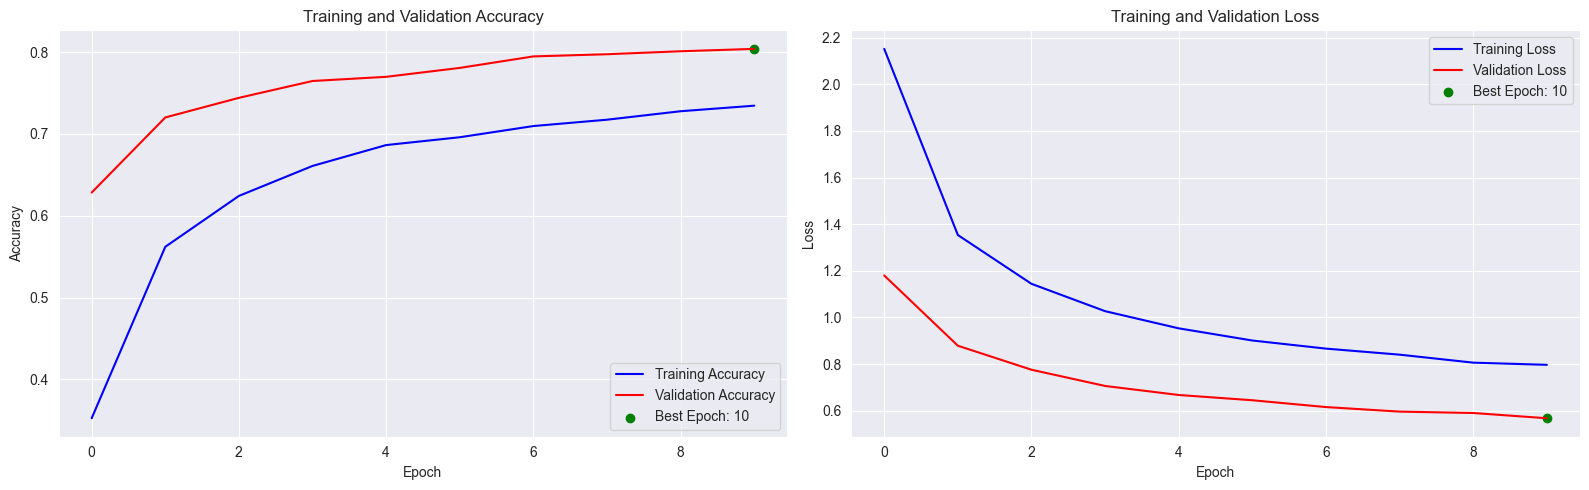

In [15]:
import seaborn as sns

best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
sns.set_style('darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [16]:
print(f"accuracy is : {round(history.history['accuracy'][best_epoch-1],2)}")
print(f"val accuracy is: {round(history.history['val_accuracy'][best_epoch-1],2)}")

accuracy is : 0.73
val accuracy is: 0.8


In [17]:
def yolo_v8_classification(input_shape, num_classes):
    """
    Builds a YOLOv8-like model for multi-class classification.

    Args:
        input_shape (tuple): Shape of the input images (H, W, C).
        num_classes (int): Number of output classes.

    Returns:
        model (tf.keras.Model): YOLOv8-like classification model.
    """
    inputs = Input(shape=input_shape)

    # Backbone (Feature Extraction)
    x = Conv2D(32, (3, 3), strides=1, padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Spatial Pyramid Pooling (SPP) Block
    spp1 = MaxPooling2D(pool_size=5, strides=1, padding="same")(x)
    spp2 = MaxPooling2D(pool_size=9, strides=1, padding="same")(x)
    spp3 = MaxPooling2D(pool_size=13, strides=1, padding="same")(x)
    x = Concatenate()([x, spp1, spp2, spp3])

    # Classification Head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(220, activation="relu")(x)  # Fully connected layer
    x = Dropout(0.5)(x)
    x = Dense(60, activation="relu")(x)  # Fully connected layer
    outputs = Dense(num_classes, activation="softmax", name="root")(x)  # Output layer

    # Model
    model = Model(inputs, outputs, name="YOLOv8_Like_Classification")
    return model

model = yolo_v8_classification(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "YOLOv8_Like_Classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 80,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 512)              │            │ max_pooling2d[0]… │
│                     │                   │            │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 220)       │    112,860 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 220)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 60)        │     13,260 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 223,227 (871.98 KB)

 Trainable params: 221,755 (866.23 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [18]:
optimizer = Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train,y_train,
                        epochs= 5,
                        validation_data = (X_val,y_val),
                   callbacks=early_stopping)

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 98s 188ms/step - accuracy: 0.3821 - loss: 2.0474 - val_accuracy: 0.1691 - val_loss: 4.9133
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 104s 201ms/step - accuracy: 0.6782 - loss: 0.9897 - val_accuracy: 0.8101 - val_loss: 0.5552
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 106s 205ms/step - accuracy: 0.7632 - loss: 0.7228 - val_accuracy: 0.6771 - val_loss: 0.9467
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 100s 194ms/step - accuracy: 0.8060 - loss: 0.5864 - val_accuracy: 0.7590 - val_loss: 0.6984
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 100s 195ms/step - accuracy: 0.8428 - loss: 0.4750 - val_accuracy: 0.9016 - val_loss: 0.2809


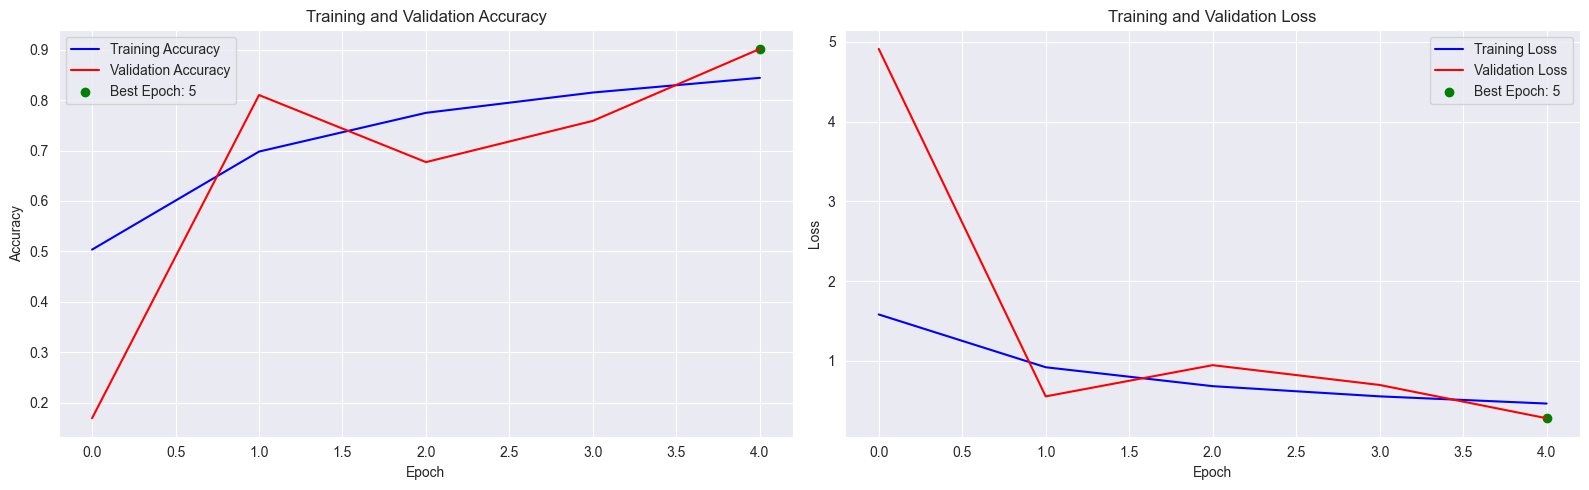

In [20]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
sns.set_style('darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [21]:
print(f"accuracy is : {round(history.history['accuracy'][best_epoch-1],2)}")
print(f"val accuracy is: {round(history.history['val_accuracy'][best_epoch-1],2)}")

accuracy is : 0.84
val accuracy is: 0.9


In [22]:
model.save("../saved models/yolov8_plant_disease_model.keras")